[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.axes_style("whitegrid")

import glob

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

# Paths and Consts

In [83]:
r_hand_path = 'data\\HandRight.csv'
train_path = 'data\\Training\\*\\*'
test_path = 'data\\Validation\\*\\*'
START_DELAY = 7

# Funcs

In [3]:
def prepare_data(df):
    df.rename(str.strip, axis='columns', inplace=True)
    df.dropna(inplace=True)
    df = df[df['Time']>=df['Time'][0]+START_DELAY]
    df.drop('# hands', axis=1, inplace=True)
    return df

In [4]:
def add_suffix_on_split(split_df1, split_df2):
    if split_df1['Hand Type'][0] == 'left':
        split_df1 = split_df1.add_suffix(' Left')
        split_df2 = split_df2.add_suffix(' Right')
    else:
        split_df1 = split_df1.add_suffix(' Right')
        split_df2 = split_df2.add_suffix(' Left')
    return split_df1, split_df2

In [5]:
def combine_hands(df, split_df2=None):
    if split_df2 is None:
        split1 = np.arange(0, df.shape[0], 2)
        split2 = np.arange(1, df.shape[0], 2)
        
        if df['Hand Type'].values[0] == 'left':
            split_df1 = df.iloc[split1, :]
            split_df2 = df.iloc[split2, :]
        else:
            split_df1 = df.iloc[split2, :]
            split_df2 = df.iloc[split1, :]
    else:
        split_df1 = df.copy()

    if split_df1.shape[0] > split_df2.shape[0]:
        split_df1 = split_df1.iloc[np.arange(split_df2.shape[0]), :]
    else:
        split_df2 = split_df2.iloc[np.arange(split_df1.shape[0]), :]

    split_df1.set_index(np.arange(split_df1.shape[0]), inplace=True)
    split_df2.set_index(np.arange(split_df1.shape[0]), inplace=True)
    
    split_df1 = split_df1.add_suffix(' Left')
    split_df2 = split_df2.add_suffix(' Right')

    df = pd.concat([split_df1, split_df2], axis=1, sort=False)
    df.drop(['Time Left', 'Time Right'], axis=1, inplace=True)
    
    return df

In [66]:
def cut_df(df):
    start_time = df.iloc[0, 0]
    end_time = df.iloc[len(df)-1, 0]
    total_time = (end_time - start_time)
    start_frame = df.iloc[0, 1]
    end_frame = df.iloc[len(df)-1, 1]
    total_frame = (end_frame - start_frame)
#     jump = int(total_time)//2
    jump = 1
    if jump%2 == 1:
        jump += 1
    
    tmp1 = np.arange(0, df.shape[0], jump)
    tmp2 = np.arange(1, df.shape[0], jump)
    df['tmp'] = np.arange(df.shape[0])
    df_cut = df[df['tmp'].isin(np.append(tmp1, tmp2))]
    df_cut.drop('tmp', axis=1, inplace=True)
    
    return df_cut

In [7]:
def mod_df(df, r_hand_df=None):
    df = prepare_data(df)    
    df_cut = cut_df(df)
    df_cut = combine_hands(df_cut, r_hand_df)
    
    return df_cut

## data mod

In [106]:
def pars_data(path):
    pars_df = pd.DataFrame()

    r_hand_df = pd.read_csv(r_hand_path)
    r_hand_df = prepare_data(r_hand_df)
#     print(r_hand_df.shape)

    for name in glob.glob(path):
#         print(name)
        df = pd.read_csv(name)
#         print('before', df.shape[0])

        df.dropna(inplace=True)
        if 'Alone' in name[-11:]: #add r hand
            df = mod_df(df, r_hand_df.copy()) 
            df['value'] = 0

        else:
            df  = mod_df(df)
            if 'Spontan' in name[-11:]:
                df['value'] = 1
            elif 'Sync' in name[-11:]:
                df['value'] = 2
            else:
                print('ERORR')

#         print('after', df.shape)
        pars_df = pars_df.append(df, ignore_index=True)
    
    return pars_df

In [107]:
train_df = pars_data(train_path)
test_df = pars_data(test_path)

C:\Users\mthee\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [108]:
train_df.iloc[:, 8:25]

,Pitch Left,Roll Left,Yaw Left,Wrist Pos X Left,Wrist Pos Y Left,Wrist Pos Z Left,Elbow pos X Left,Elbow Pos Y Left,Elbow Pos Z Left,Grab Strenth Left,Grab Angle Left,Pinch Strength Left,Frame ID Right,Hand Type Right,Position X Right,Position Y Right,Position Z Right
0,2.147859,0.867143,2.206444,-154.8575,186.2046,53.51289,-346.8731,25.919320,27.82433,0.0,0.030295,0.0,98073,right,136.72260,201.6860,-35.08604
1,2.129599,0.871616,2.202041,-154.9149,187.6303,53.10642,-345.1480,25.046670,28.62841,0.0,0.019477,0.0,98075,right,137.02470,205.0279,-32.50590
2,2.122263,0.860277,2.194173,-154.9025,188.1121,52.70757,-345.9719,26.508460,28.25391,0.0,0.000000,0.0,98076,right,137.58480,206.9182,-30.75200
3,2.104647,0.857637,2.176447,-155.3785,189.6157,52.05566,-346.9663,28.690010,27.19080,0.0,0.000000,0.0,98078,right,138.65750,210.6163,-26.84100
4,2.081292,0.874105,2.161908,-156.0525,192.3551,51.94658,-346.5293,30.469920,24.87281,0.0,0.000000,0.0,98080,right,139.30040,214.3510,-22.17304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177678,0.629213,1.887313,0.429763,-107.8500,127.8215,32.85250,-318.7630,20.751860,138.01250,0.0,0.000000,0.0,67304,right,97.75611,205.9629,30.04651
177679,0.667618,1.870251,0.434664,-108.0805,128.1729,33.40391,-314.6744,14.308990,139.99090,0.0,0.000000,0.0,67306,right,98.93275,208.3153,34.85991
177680,0.725945,1.838532,0.456099,-109.0018,129.5246,33.89856,-304.9600,-0.548136,142.01090,0.0,0.000000,0.0,67309,right,101.91230,212.0264,42.53568
177681,0.762549,1.824587,0.459446,-109.7250,130.7078,34.03360,-295.5957,-14.978170,140.02630,0.0,0.000000,0.0,67311,right,103.84750,214.7484,47.07082


In [109]:
train_df.isna().sum()

Frame ID Left           0
Hand Type Left          0
Position X Left         0
Position Y Left         0
Position Z Left         0
Velocity X Left         0
Velocity Y Left         0
Velocity Z Left         0
Pitch Left              0
Roll Left               0
Yaw Left                0
Wrist Pos X Left        0
Wrist Pos Y Left        0
Wrist Pos Z Left        0
Elbow pos X Left        0
Elbow Pos Y Left        0
Elbow Pos Z Left        0
Grab Strenth Left       0
Grab Angle Left         0
Pinch Strength Left     0
Frame ID Right          0
Hand Type Right         0
Position X Right        0
Position Y Right        0
Position Z Right        0
Velocity X Right        0
Velocity Y Right        0
Velocity Z Right        0
Pitch Right             0
Roll Right              0
Yaw Right               0
Wrist Pos X Right       0
Wrist Pos Y Right       0
Wrist Pos Z Right       0
Elbow pos X Right       0
Elbow Pos Y Right       0
Elbow Pos Z Right       0
Grab Strenth Right      0
Grab Angle R

In [19]:
train_df.nunique()

Frame ID Left            95700
Hand Type Left               2
Position X Left         173804
Position Y Left         169386
Position Z Left         176522
Velocity X Left         176849
Velocity Y Left         176716
Velocity Z Left         176902
Pitch Left              171965
Roll Left               175405
Yaw Left                172553
Wrist Pos X Left        171328
Wrist Pos Y Left        167787
Wrist Pos Z Left        176295
Elbow pos X Left        172045
Elbow Pos Y Left        176915
Elbow Pos Z Left        175191
Grab Strenth Left        25800
Grab Angle Left         126728
Pinch Strength Left      42556
Frame ID Right           80863
Hand Type Right              2
Position X Right        121554
Position Y Right        121373
Position Z Right        124931
Velocity X Right        125098
Velocity Y Right        125051
Velocity Z Right        125181
Pitch Right             122916
Roll Right              123775
Yaw Right               124083
Wrist Pos X Right       121242
Wrist Po

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177683 entries, 0 to 177682
Data columns (total 41 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Frame ID Left         177683 non-null  int64  
 1   Hand Type Left        177683 non-null  object 
 2   Position X Left       177683 non-null  float64
 3   Position Y Left       177683 non-null  float64
 4   Position Z Left       177683 non-null  float64
 5   Velocity X Left       177683 non-null  float64
 6   Velocity Y Left       177683 non-null  float64
 7   Velocity Z Left       177683 non-null  float64
 8   Pitch Left            177683 non-null  float64
 9   Roll Left             177683 non-null  float64
 10  Yaw Left              177683 non-null  float64
 11  Wrist Pos X Left      177683 non-null  float64
 12  Wrist Pos Y Left      177683 non-null  float64
 13  Wrist Pos Z Left      177683 non-null  float64
 14  Elbow pos X Left      177683 non-null  float64
 15  

In [110]:
train_df.drop(['Hand Type Left', 'Hand Type Right'], axis=1, inplace=True)
test_df.drop(['Hand Type Left', 'Hand Type Right'], axis=1, inplace=True)

In [111]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177683 entries, 0 to 177682
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Frame ID Left         177683 non-null  int64  
 1   Position X Left       177683 non-null  float64
 2   Position Y Left       177683 non-null  float64
 3   Position Z Left       177683 non-null  float64
 4   Velocity X Left       177683 non-null  float64
 5   Velocity Y Left       177683 non-null  float64
 6   Velocity Z Left       177683 non-null  float64
 7   Pitch Left            177683 non-null  float64
 8   Roll Left             177683 non-null  float64
 9   Yaw Left              177683 non-null  float64
 10  Wrist Pos X Left      177683 non-null  float64
 11  Wrist Pos Y Left      177683 non-null  float64
 12  Wrist Pos Z Left      177683 non-null  float64
 13  Elbow pos X Left      177683 non-null  float64
 14  Elbow Pos Y Left      177683 non-null  float64
 15  

In [112]:
train_df = train_df.sample(frac=1, random_state=0).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=0).reset_index(drop=True)

In [113]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]
X_val = test_df.iloc[:, :-1]
y_val = test_df.iloc[:, -1]

In [114]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X)
tmp = mm_scaler.transform(X)
tmpdf = pd.DataFrame(tmp)
# tmpdf = tmpdf.rename(columns=(np.arange(1, 22)))
for i in range(tmpdf.shape[1]):
    tmpdf.rename(columns={i: X.columns[i]}, inplace=True)
X = tmpdf
tmp = mm_scaler.transform(X_val)
tmpdf = pd.DataFrame(tmp)
# tmpdf = tmpdf.rename(columns=(np.arange(1, 22)))
for i in range(tmpdf.shape[1]):
    tmpdf.rename(columns={i: X_val.columns[i]}, inplace=True)
X_val = tmpdf
X

,Frame ID Left,Position X Left,Position Y Left,Position Z Left,Velocity X Left,Velocity Y Left,Velocity Z Left,Pitch Left,Roll Left,Yaw Left,...,Yaw Right,Wrist Pos X Right,Wrist Pos Y Right,Wrist Pos Z Right,Elbow pos X Right,Elbow Pos Y Right,Elbow Pos Z Right,Grab Strenth Right,Grab Angle Right,Pinch Strength Right
0,0.150967,0.401582,0.143296,0.712393,0.513237,0.583654,0.507852,0.788832,0.616886,0.787916,...,0.396228,0.650388,0.481990,0.502004,0.684114,0.733670,0.655200,0.401809,0.476427,0.459398
1,0.888178,0.346203,0.108148,0.629988,0.606768,0.512861,0.496474,0.636565,0.540581,0.713807,...,0.276047,0.863833,0.298833,0.387309,0.859098,0.394475,0.391603,0.000000,0.227637,0.000000
2,0.351549,0.376181,0.087646,0.610226,0.560021,0.557630,0.495049,0.629424,0.785231,0.531574,...,0.356721,0.809763,0.345034,0.391496,0.823117,0.392677,0.300978,0.000000,0.037567,0.000000
3,0.318263,0.423996,0.224700,0.627013,0.542491,0.543665,0.500863,0.610365,0.571592,0.671235,...,0.465787,0.655691,0.332000,0.562826,0.650526,0.416072,0.675878,0.000000,0.824294,0.572275
4,0.206164,0.337571,0.140748,0.717730,0.555575,0.539352,0.551243,0.722055,0.521945,0.745858,...,0.451203,0.797893,0.319972,0.605558,0.823737,0.461790,0.585398,0.000000,0.150294,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177678,0.526748,0.400705,0.124730,0.638346,0.545117,0.591838,0.463699,0.602809,0.801414,0.535344,...,0.470878,0.807388,0.309283,0.429956,0.770869,0.330113,0.454655,0.000000,0.066729,0.000000
177679,0.387064,0.371875,0.142734,0.549530,0.597168,0.496157,0.466346,0.587808,0.015117,0.637907,...,0.356125,0.857040,0.368548,0.441107,0.806246,0.322166,0.357924,0.000000,0.030884,0.000000
177680,0.275692,0.393071,0.084549,0.603180,0.569462,0.547135,0.513140,0.475255,0.511905,0.586271,...,0.438204,0.906925,0.373105,0.309195,0.828608,0.384208,0.365978,0.000000,0.147208,0.000000
177681,0.314183,0.374366,0.165725,0.607916,0.578521,0.550851,0.510347,0.680318,0.730877,0.598575,...,0.379250,0.683729,0.363045,0.441371,0.735480,0.592245,0.560556,0.000000,0.120625,0.000000


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

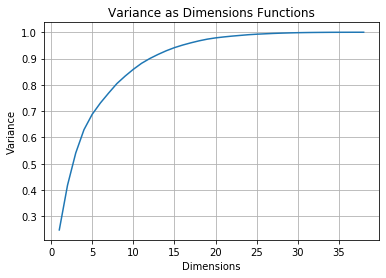

In [117]:
pca = PCA(random_state=0)
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [118]:
pca = PCA(random_state=0, n_components=0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)
d = len(pca.singular_values_)
print('the number of vectors after pca is {}'.format(d))

the number of vectors after pca is 12


In [33]:
# pca = PCA(n_components=2).fit(X_train)
X_pc = pca.transform(X_train)

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['a','b','c','d','e']
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_pca = pd.DataFrame(dic.items())
df_pca

IndexError: list index out of range

In [ ]:
def ppp():
    # Sample dataframe with date index and five variables 
    np.random.seed(123)
    df = train_df.iloc[:, :-1]
    # df = pd.DataFrame(np.random.uniform(-0.25,0.25,size=(5, 5)),
    #               columns = ['Var A','Var B','Var C', 'Var D', 'Var E'])
    # df['Dates'] =  pd.date_range(start = None, end = pd.datetime.today().strftime('%Y-%m-%d'),
    #                      periods=5).tolist()
    # df = df.set_index(['Dates'])

    # Compute correlations
    corr = df.corr()

    # Exclude duplicate correlations by masking uper right values
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap
    cmap = sns.diverging_palette(10, 250, as_cmap=True)

    # Draw correlation plot
    sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    plt.show()

In [119]:
def evaluate(true, pred):
#     model_accuracy = roc_auc_score(true, pred)
#     null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
#     print("Null AUC Score: {:.5f}".format(null_accuracy))
#     print("Model AUC Score: {:.5f}".format(model_accuracy))

#     if null_accuracy >= model_accuracy:
#         print("The model isn't effective")
# #         return
#     else:
#         print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))
    print(accuracy_score(true, pred))

In [120]:
gnb = GaussianNB()

gnb.fit(X_train_pca, y_train)
predictions = gnb.predict(X_test_pca)
evaluate(y_test, predictions)

# gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=10)

# score_models('GaussianNB', gnb_scores)

confusion_matrix:
 [[15327  1142   283]
 [  410 10709  7442]
 [  161  3760 14071]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     16752
           1       0.69      0.58      0.63     18561
           2       0.65      0.78      0.71     17992

    accuracy                           0.75     53305
   macro avg       0.77      0.76      0.76     53305
weighted avg       0.76      0.75      0.75     53305

0.7524059656692618


In [121]:
predictions = gnb.predict(X_val_pca)
evaluate(y_val, predictions)

confusion_matrix:
 [[14700  1180   219]
 [  275  9121  6873]
 [  226  1956 14032]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     16099
           1       0.74      0.56      0.64     16269
           2       0.66      0.87      0.75     16214

    accuracy                           0.78     48582
   macro avg       0.79      0.78      0.78     48582
weighted avg       0.79      0.78      0.78     48582

0.7791568893828991


In [40]:
base_estimetor = DecisionTreeClassifier(max_depth=12, random_state=0)
adboost = AdaBoostClassifier(base_estimetor, learning_rate=0.08, n_estimators=500, random_state=93)
adboost.fit(X_train_pca,y_train)
y_pred = adboost.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16752
           1       0.99      1.00      1.00     18561
           2       1.00      0.99      1.00     17992

    accuracy                           1.00     53305
   macro avg       1.00      1.00      1.00     53305
weighted avg       1.00      1.00      1.00     53305



In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9287121283181691

In [47]:
dtc = DecisionTreeClassifier(max_depth=12, random_state=0)
dtc.fit(X_train_pca,y_train)
predictions = dtc.predict(X_test_pca)
evaluate(y_test, predictions)
accuracy_score(y_test, predictions)

confusion_matrix:
 [[16533   122    97]
 [  143 16731  1687]
 [   65  1686 16241]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16752
           1       0.90      0.90      0.90     18561
           2       0.90      0.90      0.90     17992

    accuracy                           0.93     53305
   macro avg       0.93      0.93      0.93     53305
weighted avg       0.93      0.93      0.93     53305



0.9287121283181691

In [65]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train_pca,y_train)
predictions = dtc.predict(X_test_pca)
evaluate(y_test, predictions)
accuracy_score(y_test, predictions)

confusion_matrix:
 [[6736   47   14]
 [  65 6401  910]
 [  25  832 6438]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6797
           1       0.88      0.87      0.87      7376
           2       0.87      0.88      0.88      7295

    accuracy                           0.91     21468
   macro avg       0.91      0.91      0.91     21468
weighted avg       0.91      0.91      0.91     21468

0.9118222470653997


0.9118222470653997

In [64]:
rnf = RandomForestClassifier(random_state=0)
rnf.fit(X_train_pca,y_train)
predictions = rnf.predict(X_test_pca)
evaluate(y_test, predictions)
accuracy_score(y_test, predictions)

confusion_matrix:
 [[6788    9    0]
 [  18 7083  275]
 [   9  462 6824]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6797
           1       0.94      0.96      0.95      7376
           2       0.96      0.94      0.95      7295

    accuracy                           0.96     21468
   macro avg       0.96      0.96      0.96     21468
weighted avg       0.96      0.96      0.96     21468

0.9639929196944289


0.9639929196944289

In [122]:
rnf = RandomForestClassifier(random_state=0)
rnf.fit(X_train_pca,y_train)
predictions = rnf.predict(X_test_pca)
evaluate(y_test, predictions)

predictions = rnf.predict(X_val_pca)
evaluate(y_val, predictions)

confusion_matrix:
 [[16751     0     1]
 [   20 18442    99]
 [    8   209 17775]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16752
           1       0.99      0.99      0.99     18561
           2       0.99      0.99      0.99     17992

    accuracy                           0.99     53305
   macro avg       0.99      0.99      0.99     53305
weighted avg       0.99      0.99      0.99     53305

0.9936778913797956
confusion_matrix:
 [[15994   100     5]
 [   28 13570  2671]
 [    0  3626 12588]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     16099
           1       0.78      0.83      0.81     16269
           2       0.82      0.78      0.80     16214

    accuracy                           0.87     48582
   macro avg       0.87      0.87      0.87     48582
weighted avg       0.87      0.87      0.87     48582

0.8676464534189617
